## Imports

In [1]:
import random
random.seed(42)

In [2]:
import pandas as pd
import re
import numpy as np
from collections import Counter

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

## Load the Data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train = train.reindex(sorted(train.columns), axis=1).reset_index(drop=True)
test = test.reindex(sorted(test.columns), axis=1).reset_index(drop=True)

In [6]:
complete = pd.concat([train, test], ignore_index=True)
complete.shape

(12800, 17)

In [7]:
print(train.shape)
train.head()

(8000, 17)


,availability,bathrooms_number,car_parking,conditions,condominium_fees,energy_efficiency_class,floor,heating_centralized,lift,other_features,rooms_number,square_meters,total_floors_in_building,w,y,year_of_construction,zone
0,available,2,no,excellent / refurbished,417,g,2,central,yes,optic fiber | security door | balcony | full d...,3,135,7,1,1125000,NaN,quadronno - crocetta
1,available,1,1 in garage/box,excellent / refurbished,No condominium fees,e,1,central,yes,optic fiber | video entryphone | alarm system ...,2,57,7,1,500000,2010.0,porta romana - medaglie d'oro
2,available,1,no,excellent / refurbished,200,e,1,central,yes,electric gate | optic fiber | video entryphone...,3,92,8,1,395000,1960.0,gallaratese
3,NaN,1,no,excellent / refurbished,208,f,mezzanine,central,no,optic fiber | video entryphone | security door...,2,63,8,1,340000,NaN,martini - insubria
4,available,1,no,excellent / refurbished,80,g,1,independent,no,optic fiber | security door | internal exposur...,1,38,4,1,199000,1930.0,navigli - darsena


In [8]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   availability              11120 non-null  object 
 1   bathrooms_number          12761 non-null  object 
 2   car_parking               12800 non-null  object 
 3   conditions                12681 non-null  object 
 4   condominium_fees          11391 non-null  object 
 5   energy_efficiency_class   11440 non-null  object 
 6   floor                     12800 non-null  object 
 7   heating_centralized       12686 non-null  object 
 8   lift                      12569 non-null  object 
 9   other_features            12765 non-null  object 
 10  rooms_number              12800 non-null  object 
 11  square_meters             12800 non-null  int64  
 12  total_floors_in_building  12689 non-null  object 
 13  w                         8000 non-null   float64
 14  y     

## Data Cleaning 

Extract additional features from 'other_features' variable

In [9]:
features_list = [complete.other_features[x].split('|') if type(complete.other_features[x]) == str else '' for x in range(len(complete.other_features))]

In [10]:
def split_string_by_pattern(input_string):
    pattern = r'(.*?\/\s*pvc)([a-z].*)'  
    match = re.match(pattern, input_string)
    
    if match:
        part1 = match.group(1)  
        part2 = match.group(2)  
        return [part1, part2]
    else:
        return [input_string]


In [11]:
def modify_exposure_string(input_string):
    pattern = r'^(exposure)\s+(?P<directions>[a-zA-Z\s,]+)'
    matches = re.finditer(pattern, input_string)
    modified_strings = []
    pattern_matched = False  
    
    for match in matches:
        pattern_matched = True 
        directions = match.group('directions').strip()
        
        if directions:
            direction_list = [direction.strip() for direction in directions.split(',')]
            for direction in direction_list:
                modified_string = f'exposure {direction}'
                modified_strings.append(modified_string)
    if not pattern_matched:
        modified_strings = [input_string]
    
    return modified_strings

In [12]:
def remove_backslash(input_string):
    index = input_string.find('/')

    if index != -1:  
        modified_string = input_string[:index].strip() 
    else:
        modified_string = input_string 
    return modified_string

In [13]:
def remove_innermost_list(nested_list):
    result = []
    
    for item in nested_list:
        if isinstance(item, list):
            result.extend(item)  
        else:
            result.append(item)  
    
    return list(set(result))

In [14]:
for i in range(len(features_list)):
    features_list[i] = [name.strip() for name in features_list[i]]
    features_list[i] = [split_string_by_pattern(name) for name in features_list[i]]
    features_list[i] = remove_innermost_list(features_list[i])
    features_list[i] = [modify_exposure_string(name) for name in features_list[i]]
    features_list[i] = remove_innermost_list(features_list[i])
    features_list[i] = [remove_backslash(name) for name in features_list[i]]
    features_list[i] = [['alarm system', 'balcony'] if name == 'alarm system1 balcony' else name for name in features_list[i]]
    features_list[i] = [['property land', 'balcony'] if name == 'property land1 balcony' else name for name in features_list[i]]
    features_list[i] = ['balcony' if name in ['6 balconies', '8 balconies', '1 balcony'] else name for name in features_list[i]]
    features_list[i] = remove_innermost_list(features_list[i])

features_list[0:3]

[['balcony', 'optic fiber', 'security door', 'full day concierge', 'cellar'],
 ['partially furnished',
  'window frames in double glass',
  'external exposure',
  'centralized tv system',
  'half-day concierge',
  'video entryphone',
  'optic fiber',
  'security door',
  'alarm system',
  'closet'],
 ['balcony',
  'electric gate',
  'furnished',
  'shared garden',
  'window frames in double glass',
  'half-day concierge',
  'video entryphone',
  'internal exposure',
  'optic fiber',
  'security door',
  'closet',
  'cellar']]

In [15]:
unique_names = list(set(name for names in features_list for name in names))
print(len(unique_names))
unique_names[0:6]

40


['tennis court',
 'window frames in glass',
 'window frames in triple glass',
 'exposure east',
 'exposure west',
 'only kitchen furnished']

Copy the dataset and add the extracted features

In [16]:
complete_augmented = complete.copy()
complete_augmented['features_list'] = features_list

In [17]:
for feature in unique_names:
    complete_augmented[feature] = [True if feature in complete_augmented.features_list[x] else False for x in range(len(complete_augmented.features_list))]

In [18]:
complete_augmented.head()

,availability,bathrooms_number,car_parking,conditions,condominium_fees,energy_efficiency_class,floor,heating_centralized,lift,other_features,...,hydromassage,exposure south,disabled access,balcony,external exposure,tv system with satellite dish,half-day concierge,video entryphone,internal exposure,exposure north
0,available,2,no,excellent / refurbished,417,g,2,central,yes,optic fiber | security door | balcony | full d...,...,False,False,False,True,False,False,False,False,False,False
1,available,1,1 in garage/box,excellent / refurbished,No condominium fees,e,1,central,yes,optic fiber | video entryphone | alarm system ...,...,False,False,False,False,True,False,True,True,False,False
2,available,1,no,excellent / refurbished,200,e,1,central,yes,electric gate | optic fiber | video entryphone...,...,False,False,False,True,False,False,True,True,True,False
3,NaN,1,no,excellent / refurbished,208,f,mezzanine,central,no,optic fiber | video entryphone | security door...,...,False,False,False,False,False,False,False,True,False,False
4,available,1,no,excellent / refurbished,80,g,1,independent,no,optic fiber | security door | internal exposur...,...,False,False,False,False,False,False,False,False,True,False


## Study each feature

In [19]:
complete_augmented = complete_augmented.drop(['other_features'], axis = 1)
complete_augmented.head()

,availability,bathrooms_number,car_parking,conditions,condominium_fees,energy_efficiency_class,floor,heating_centralized,lift,rooms_number,...,hydromassage,exposure south,disabled access,balcony,external exposure,tv system with satellite dish,half-day concierge,video entryphone,internal exposure,exposure north
0,available,2,no,excellent / refurbished,417,g,2,central,yes,3,...,False,False,False,True,False,False,False,False,False,False
1,available,1,1 in garage/box,excellent / refurbished,No condominium fees,e,1,central,yes,2,...,False,False,False,False,True,False,True,True,False,False
2,available,1,no,excellent / refurbished,200,e,1,central,yes,3,...,False,False,False,True,False,False,True,True,True,False
3,NaN,1,no,excellent / refurbished,208,f,mezzanine,central,no,2,...,False,False,False,False,False,False,False,True,False,False
4,available,1,no,excellent / refurbished,80,g,1,independent,no,1,...,False,False,False,False,False,False,False,False,True,False


Bathrooms 

In [20]:
complete_augmented.bathrooms_number.value_counts()

bathrooms_number
1     7918
2     4010
3      677
3+     156
Name: count, dtype: int64

In [21]:
def baths(x):
    if x is np.nan:
        return x
    if x == '3+':
        return 5
    else:
        return int(x)

In [22]:
complete_augmented.bathrooms_number = [baths(complete_augmented.bathrooms_number[x]) for x in range(len(complete_augmented.bathrooms_number))]

Rooms number

In [23]:
complete_augmented.rooms_number.value_counts()

rooms_number
3     4743
2     4434
4     1956
1      714
5      609
5+     344
Name: count, dtype: int64

In [24]:
def rooms(x):
    if x == '5+':
        return 7
    else:
        return int(x)

In [25]:
complete_augmented.rooms_number = [rooms(complete_augmented.rooms_number[x]) for x in range(len(complete_augmented.rooms_number))]

Car_parking (define 4 classes: 'no', 'shared', 'garage', 'shared and garage')

In [26]:
complete_augmented.car_parking.value_counts()

car_parking
no                                       9758
1 in garage/box                          1753
1 in shared parking                       650
2 in garage/box                           281
1 in garage/box, 1 in shared parking      224
2 in shared parking                        43
2 in garage/box, 2 in shared parking       25
2 in garage/box, 1 in shared parking       19
1 in garage/box, 2 in shared parking       12
3 in shared parking                        10
4 in shared parking                         5
1 in garage/box, 5 in shared parking        3
2 in garage/box, 3 in shared parking        3
1 in garage/box, 3 in shared parking        2
2 in garage/box, 6 in shared parking        1
7 in garage/box, 3 in shared parking        1
2 in garage/box, 7 in shared parking        1
5 in shared parking                         1
20 in shared parking                        1
9 in shared parking                         1
1 in garage/box, 4 in shared parking        1
2 in garage/box, 16 in

In [27]:
def parking(input_string):
    if ('shared' in input_string) and ('garage' in input_string):
        if int(input_string[0]) > 1:
            return 'more_shared_and_garage'
        else:
            return 'shared_and_garage'
    elif 'shared' in input_string:
        return 'shared'
    elif 'garage' in input_string:
        if int(input_string[0]) > 1:
            return 'more_garage'
        else:
            return 'garage'
    else:
        return input_string

complete_augmented.car_parking = [parking(complete_augmented.car_parking[x]) for x in range(len(complete_augmented.car_parking))]

In [28]:
complete_augmented.car_parking.value_counts()

car_parking
no                        9758
garage                    1753
shared                     713
more_garage                282
shared_and_garage          242
more_shared_and_garage      52
Name: count, dtype: int64

Deal with 'total floor in building'

In [29]:
complete_augmented.total_floors_in_building.value_counts()

total_floors_in_building
5          2307
4          2195
6          1934
8          1564
7          1448
3          1215
2           767
1 floor     472
9           386
10          105
11           65
12           50
14           37
15           32
23           25
13           20
16           16
18           15
19           14
21            6
17            6
22            4
27            3
24            3
Name: count, dtype: int64

In [30]:
def total_floors(input_string):
    if input_string == '1 floor' or input_string == '2':
        return '0-2'
    elif input_string is np.nan:
        return input_string
    elif 6 < int(input_string) < 10:
        return '7-9'
    elif 3 <= int(input_string) <= 4:
        return '3-4' 
    elif 5 <= int(input_string) <= 6:
        return '5-6'
    elif 10 <= int(input_string):
        return '10+'
    else:
        return input_string

complete_augmented.total_floors_in_building = [total_floors(complete_augmented.total_floors_in_building[x]) for x in range(len(complete_augmented.total_floors_in_building))]

In [31]:
complete_augmented.total_floors_in_building.value_counts()

total_floors_in_building
5-6    4241
3-4    3410
7-9    3398
0-2    1239
10+     401
Name: count, dtype: int64

Effieciency class (what to do with ','?)

In [32]:
complete_augmented.energy_efficiency_class.value_counts()

energy_efficiency_class
g    3806
f    2315
e    1706
a    1517
d    1118
c     492
b     484
,       2
Name: count, dtype: int64

In [33]:
complete_augmented.energy_efficiency_class = complete_augmented.energy_efficiency_class.replace(',', np.nan)

In [34]:
def energy_transform(x):
    if x == 'g':
        return 1
    elif x == 'f':
        return 2
    elif x == 'e':
        return 3
    elif x == 'd':
        return 4
    elif x == 'c':
        return 5
    elif x == 'b':
        return 6
    elif x == 'a':
        return 7

complete_augmented.energy_efficiency_class = [energy_transform(complete_augmented.energy_efficiency_class[x]) for x in range(len(complete_augmented.energy_efficiency_class))]
complete_augmented.energy_efficiency_class.value_counts()


energy_efficiency_class
1.0    3806
2.0    2315
3.0    1706
7.0    1517
4.0    1118
5.0     492
6.0     484
Name: count, dtype: int64

Condominum fees 

In [35]:
complete_augmented.condominium_fees.value_counts()

condominium_fees
100                    990
No condominium fees    964
200                    909
150                    844
250                    745
                      ... 
247                      1
339                      1
808                      1
910                      1
5000                     1
Name: count, Length: 393, dtype: int64

In [36]:
def fees(x):
    if x is np.nan:
        return x 
    elif x == 'No condominium fees':
        return 0
    elif 0 < int(x) <= 100:
        return 1
    elif 100 < int(x) <= 200:
        return 2
    elif 200 < int(x) <= 300:
        return 3
    elif 300 < int(x) <= 400:
        return 4
    elif 400 < int(x) <= 500:
        return 5
    elif 500 < int(x) <= 600:
        return 6
    elif 600 < int(x) <= 700:
        return 7
    elif 700 < int(x) <= 800:
        return 8
    elif 800 < int(x) <= 900:
        return 9
    elif 900 < int(x):
        return 10
    

In [37]:
complete_augmented.condominium_fees = [fees(complete_augmented.condominium_fees[x]) for x in range(len(complete_augmented.condominium_fees))]

In [38]:
complete_augmented.condominium_fees.value_counts()

condominium_fees
2.0     3959
3.0     2332
1.0     2273
0.0      964
4.0      871
5.0      526
6.0      172
10.0     110
7.0       92
8.0       60
9.0       32
Name: count, dtype: int64

Availability

In [39]:
complete_augmented.availability.value_counts()

availability
available                    10665
available from 30/09/2024       21
available from 30/06/2026       18
available from 31/12/2024       17
available from 01/07/2024       15
                             ...  
available from 01/05/2027        1
available from 31/07/2023        1
available from 30/05/2026        1
available from 04/09/2026        1
available from 22/12/2024        1
Name: count, Length: 197, dtype: int64

In [40]:
def available(x):
    if type(x) == str:
        pattern = r'\b(\d{4})\b'  
        match = re.search(pattern, x)
        if match:
            year = match.group(0)
            if year in ['2020', '2022']:
                return 'available'
            elif year in ['2023', '2024']:
                return 'available_soon'
            else:
                return 'available_later'
        else:
            return x
    else:
        return x

In [41]:
complete_augmented.availability = [available(complete_augmented.availability[x]) for x in range(len(complete_augmented.availability))]
complete_augmented.availability.value_counts()

availability
available          10667
available_soon       307
available_later      146
Name: count, dtype: int64

Floor (encode it)

In [42]:
complete_augmented.floor.value_counts()

floor
1                2669
2                2045
3                1758
ground floor     1489
4                1296
mezzanine        1135
5                 892
6                 579
7                 399
semi-basement     244
8                 236
9                  58
Name: count, dtype: int64

Heating centralized

In [43]:
complete_augmented.heating_centralized.value_counts() 

heating_centralized
central        8883
independent    3803
Name: count, dtype: int64

Conditions

In [44]:
complete_augmented.conditions.value_counts()

conditions
excellent / refurbished      5271
good condition / liveable    3904
new / under construction     2187
to be refurbished            1319
Name: count, dtype: int64

Year of construction

In [45]:
complete_augmented.year_of_construction.describe()

count    11518.000000
mean      1962.545147
std         46.345888
min       1111.000000
25%       1950.000000
50%       1960.000000
75%       1978.000000
max       2027.000000
Name: year_of_construction, dtype: float64

In [46]:
def year(x):
    if x < 1900:
        return 'before 900'
    elif 1900 <= x < 1920:
        return '00-10s'
    elif 1920 <= x < 1930:
        return '20s'
    elif 1930 <= x < 1940:
        return '30s'
    elif 1940 <= x < 1950:
        return '40s'
    elif 1950 <= x < 1960:
        return '50s'
    elif 1960 <= x < 1970:
        return '60s'
    elif 1970 <= x < 1980:
        return '70s'
    elif 1980 <= x < 1990:
        return '80s'
    elif 1990 <= x < 2000:
        return '90s'
    elif 2000 <= x:
        return '200s'


In [47]:
complete_augmented.year_of_construction = [year(complete_augmented.year_of_construction[x]) for x in range(len(complete_augmented.year_of_construction))]
complete_augmented.year_of_construction.value_counts()

year_of_construction
60s           3360
200s          2381
70s           1541
50s           1051
30s            882
00-10s         731
40s            474
20s            470
80s            280
90s            188
before 900     160
Name: count, dtype: int64

Zone

In [48]:
complete_augmented.zone.value_counts()

zone
città studi                474
san siro                   424
certosa                    297
corvetto                   225
buenos aires               222
                          ... 
quadrilatero della moda      3
via fra' cristoforo          1
via marignano, 3             1
corso magenta                1
largo caioroli 2             1
Name: count, Length: 149, dtype: int64

In [49]:
def zone_grouper(x):
    if x == 'san vittore' or x == 'corso magenta' or x == 'cadorna - castello' or x == 'largo caioroli 2':
        return "sant'ambrogio"
    elif x == "ca' granda":
        return 'prato centenaro'
    elif x == 'quintosole - chiaravalle':
        return 'vigentino - fatima'
    elif x == 'porta nuova':
        return 'turati'
    elif x == 'borgogna - largo augusto' or x == 'scala - manzoni' or x == 'brera' or x == 'quadrilatero della moda':
        return 'san babila'
    elif x == 'ortica':
        return 'lambrate'
    elif x == 'quarto cagnino':
        return 'quinto romano'
    elif x == 'melchiorre gioia':
        return 'centrale'
    elif x == 'trenno':
        return 'figino'
    elif x == 'bovisasca':
        return 'dergano'
    elif x == 'city life':
        return 'sempione'
    elif x == 'rogoredo':
        return 'corvetto'
    elif x == 'lanza':
        return 'moscova'
    elif x == 'qt8':
        return 'monte stella'
    elif x == 'via canelli':
        return 'lambrate'
    elif x == 'cascina gobba':
        return 'quartiere adriano'
    elif x == 'via calizzano':
        return 'comasina'
    elif x == 'parco lambro':
        return 'lambrate'
    elif x == "via fra' cristoforo":
        return 'famagosta'
    elif x == 'via marignano, 3':
        return 'santa giulia'
    else:
        return x

complete_augmented.zone = [zone_grouper(complete_augmented.zone[x]) for x in range(len(complete_augmented.zone))]
complete_augmented.zone.value_counts()

zone
città studi         474
san siro            424
certosa             297
centrale            246
corvetto            238
                   ... 
lorenteggio          34
monte stella         32
quartiere feltre     32
quartiere olmi       30
roserio              30
Name: count, Length: 123, dtype: int64

In [50]:
complete_augmented['zone_grouped'] = complete_augmented.zone

## Missing values

In [51]:
complete_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   availability                   11120 non-null  object 
 1   bathrooms_number               12761 non-null  float64
 2   car_parking                    12800 non-null  object 
 3   conditions                     12681 non-null  object 
 4   condominium_fees               11391 non-null  float64
 5   energy_efficiency_class        11438 non-null  float64
 6   floor                          12800 non-null  object 
 7   heating_centralized            12686 non-null  object 
 8   lift                           12569 non-null  object 
 9   rooms_number                   12800 non-null  int64  
 10  square_meters                  12800 non-null  int64  
 11  total_floors_in_building       12689 non-null  object 
 12  w                              8000 non-null  

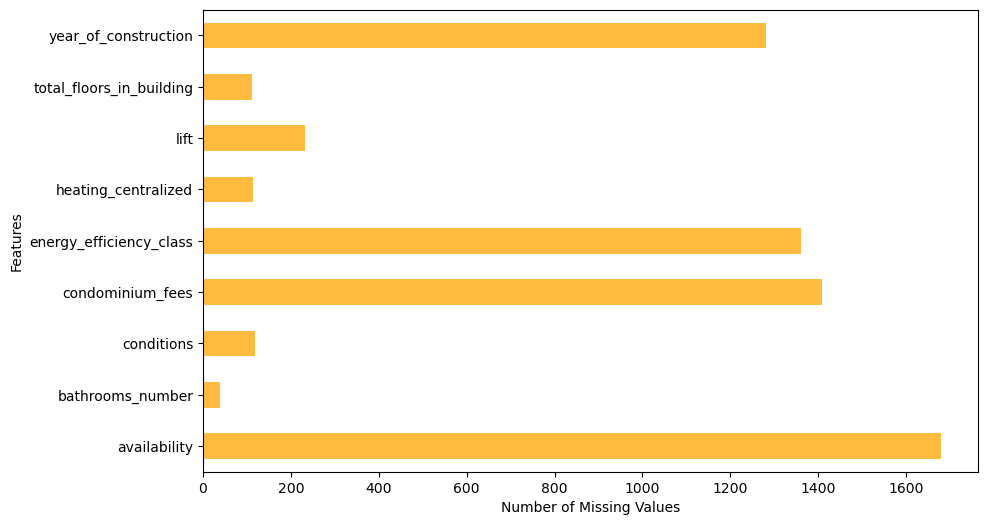

In [52]:
import matplotlib.pyplot as plt
missing_values = complete_augmented.isna().sum()[['availability', 'bathrooms_number', 'conditions', 'condominium_fees', 'energy_efficiency_class', 'heating_centralized', 'lift', 'total_floors_in_building', 'year_of_construction']]
plt.figure(figsize=(10, 6))  
missing_values.plot(kind='barh', color='orange', alpha=0.75)  
plt.ylabel('Features')
plt.xlabel('Number of Missing Values')
plt.show()

plt.show()

In [53]:
complete_augmented = complete_augmented.drop(['zone', 'features_list'], axis = 1)
complete_augmented.head()

,availability,bathrooms_number,car_parking,conditions,condominium_fees,energy_efficiency_class,floor,heating_centralized,lift,rooms_number,...,exposure south,disabled access,balcony,external exposure,tv system with satellite dish,half-day concierge,video entryphone,internal exposure,exposure north,zone_grouped
0,available,2.0,no,excellent / refurbished,5.0,1.0,2,central,yes,3,...,False,False,True,False,False,False,False,False,False,quadronno - crocetta
1,available,1.0,garage,excellent / refurbished,0.0,3.0,1,central,yes,2,...,False,False,False,True,False,True,True,False,False,porta romana - medaglie d'oro
2,available,1.0,no,excellent / refurbished,2.0,3.0,1,central,yes,3,...,False,False,True,False,False,True,True,True,False,gallaratese
3,NaN,1.0,no,excellent / refurbished,3.0,2.0,mezzanine,central,no,2,...,False,False,False,False,False,False,True,False,False,martini - insubria
4,available,1.0,no,excellent / refurbished,1.0,1.0,1,independent,no,1,...,False,False,False,False,False,False,False,True,False,navigli - darsena


Substitute *missing values* with mode and add a dummy column indicating where missing

In [54]:
complete_augmented['energy_efficiency_class_nan'] = complete_augmented.energy_efficiency_class.isna()

In [55]:
complete_augmented.energy_efficiency_class = complete_augmented.energy_efficiency_class.fillna(complete_augmented.energy_efficiency_class.mode()[0]).astype(int)

In [56]:
complete_augmented['bathrooms_number_nan'] = complete_augmented.bathrooms_number.isna()

In [57]:
complete_augmented.bathrooms_number = complete_augmented.bathrooms_number.fillna(complete_augmented.bathrooms_number.mode()[0]).astype(int)

In [58]:
complete_augmented['condominium_fees_nan'] = complete_augmented.condominium_fees.isna()

In [59]:
complete_augmented.condominium_fees = complete_augmented.condominium_fees.fillna(0).astype(int)

In [60]:
complete_augmented['availability_nan'] = complete_augmented.availability.isna()

In [61]:
complete_augmented.availability = complete_augmented.availability.fillna(complete_augmented.availability.mode()[0])

In [62]:
complete_augmented['year_of_constructiom_nan'] = complete_augmented.year_of_construction.isna()

In [63]:
complete_augmented.year_of_construction = complete_augmented.year_of_construction.fillna(complete_augmented.year_of_construction.mode()[0])

In [64]:
complete_augmented['lift_nan'] = complete_augmented.lift.isna()

In [65]:
complete_augmented.lift = complete_augmented.lift.fillna(complete_augmented.lift.mode()[0])

In [66]:
complete_augmented['total_floors_in_building_nan'] = complete_augmented.lift.isna()

In [67]:
complete_augmented.total_floors_in_building = complete_augmented.total_floors_in_building.fillna(complete_augmented.total_floors_in_building.mode()[0])

In [68]:
complete_augmented['heating_centralized_nan'] = complete_augmented.heating_centralized.isna()

In [69]:
complete_augmented.heating_centralized = complete_augmented.heating_centralized.fillna(complete_augmented.heating_centralized.mode()[0])

In [70]:
complete_augmented['conditions_nan'] = complete_augmented.conditions.isna()

In [71]:
complete_augmented.conditions = complete_augmented.conditions.fillna('good condition / liveable')

In [72]:
complete_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   availability                   12800 non-null  object 
 1   bathrooms_number               12800 non-null  int32  
 2   car_parking                    12800 non-null  object 
 3   conditions                     12800 non-null  object 
 4   condominium_fees               12800 non-null  int32  
 5   energy_efficiency_class        12800 non-null  int32  
 6   floor                          12800 non-null  object 
 7   heating_centralized            12800 non-null  object 
 8   lift                           12800 non-null  object 
 9   rooms_number                   12800 non-null  int64  
 10  square_meters                  12800 non-null  int64  
 11  total_floors_in_building       12800 non-null  object 
 12  w                              8000 non-null  

## Feature Engineering

In [73]:
## Add variables
complete_augmented['square_meters_2'] = complete_augmented['square_meters'] ** 2
complete_augmented['square_meters_3'] = complete_augmented['square_meters'] ** 3
complete_augmented['average_room'] = complete_augmented['square_meters'] / (complete_augmented['rooms_number'] + complete_augmented['bathrooms_number'] )

In [74]:
complete_augmented['large_house'] = complete_augmented.square_meters > 220

In [75]:
complete_augmented_cleaned = complete_augmented.copy()

## Encoding

In [76]:
complete_augmented = pd.get_dummies(complete_augmented_cleaned, columns=['year_of_construction', 'availability', 'lift',  'total_floors_in_building', 'car_parking', 'conditions', 'floor', 'zone_grouped', 'heating_centralized', 'large_house'], drop_first=True)
complete_augmented

,bathrooms_number,condominium_fees,energy_efficiency_class,rooms_number,square_meters,w,y,tennis court,window frames in glass,window frames in triple glass,...,zone_grouped_vercelli - wagner,zone_grouped_vialba,zone_grouped_viale ungheria - mecenate,zone_grouped_vigentino - fatima,zone_grouped_villa san giovanni,zone_grouped_vincenzo monti,zone_grouped_washington,zone_grouped_zara,heating_centralized_independent,large_house_True
0,2,5,1,3,135,1.0,1125000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,3,2,57,1.0,500000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,2,3,3,92,1.0,395000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,3,2,2,63,1.0,340000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,1,1,1,38,1.0,199000.0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,1,1,2,2,45,NaN,NaN,False,False,False,...,False,False,False,True,False,False,False,False,True,False
12796,1,1,3,2,50,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12797,1,3,3,3,85,NaN,NaN,False,True,False,...,False,False,False,False,False,False,False,False,False,False
12798,1,2,2,2,70,NaN,NaN,False,True,False,...,False,False,False,False,False,False,False,False,False,False


These are the final (non standardized) train and test set

In [77]:
X_values = complete_augmented.drop(['w', 'y'], axis = 1)
X_values_train = X_values.loc[:7999, :]
X_values_test = X_values.loc[8000:, :]
X_values_train.head()

,bathrooms_number,condominium_fees,energy_efficiency_class,rooms_number,square_meters,tennis court,window frames in glass,window frames in triple glass,exposure east,exposure west,...,zone_grouped_vercelli - wagner,zone_grouped_vialba,zone_grouped_viale ungheria - mecenate,zone_grouped_vigentino - fatima,zone_grouped_villa san giovanni,zone_grouped_vincenzo monti,zone_grouped_washington,zone_grouped_zara,heating_centralized_independent,large_house_True
0,2,5,1,3,135,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,3,2,57,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,2,3,3,92,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,3,2,2,63,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,1,1,1,38,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [78]:
y_values_train = complete_augmented.loc[:7999, 'y']
y_values_train

0       1125000.0
1        500000.0
2        395000.0
3        340000.0
4        199000.0
          ...    
7995     215000.0
7996     219000.0
7997     345000.0
7998     299000.0
7999     130000.0
Name: y, Length: 8000, dtype: float64

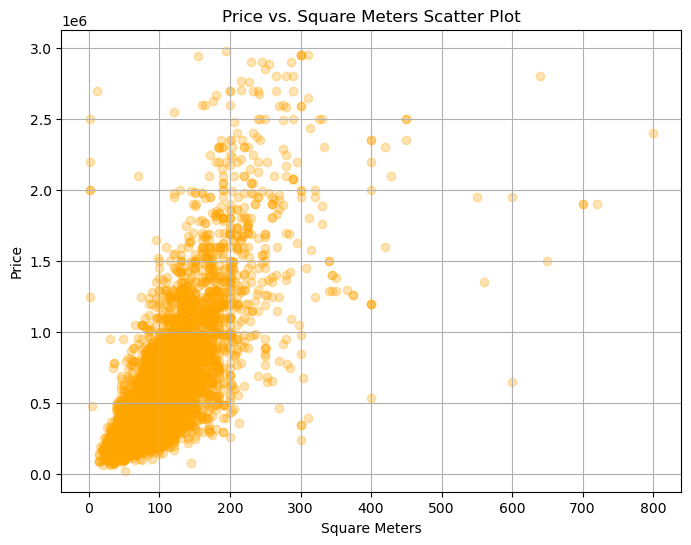

In [79]:
plt.figure(figsize=(8, 6)) 
plt.scatter(X_values_train['square_meters'], y_values_train, color='orange', alpha=0.3)
plt.title('Price vs. Square Meters Scatter Plot')
plt.xlabel('Square Meters')
plt.ylabel('Price')
plt.grid(True)  
plt.show()

# Algorithms

### Create a validation set

In [80]:
X_values_train_for_valid, X_values_valid, y_values_train_for_valid, y_values_valid = train_test_split(X_values_train, y_values_train, test_size=0.2, random_state=42)

In [81]:
X_values_train_for_valid = X_values_train_for_valid.reindex(sorted(X_values_train_for_valid.columns), axis=1).reset_index(drop=True)
X_values_valid = X_values_valid.reindex(sorted(X_values_valid.columns), axis=1).reset_index(drop=True)

### XGBOOST

In [82]:
import xgboost as xgb

## -------------might take time to run--------------

In [ ]:
param_grid = { 
    'n_estimators': [3000, 5000, 7000],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1] 
}

xgb_model = xgb.XGBRegressor(min_child_weight =  3, colsample_bytree = 0.8, colsample_bylevel = 0.8, colsample_bynode = 0.8, subsample = 0.6, random_state = 31)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1.2, n_jobs = -1)
grid_search.fit(X_values_train_for_valid, np.log(y_values_train_for_valid))

print("Best parameters:", grid_search.best_params_)

Error on the Validation set

In [83]:
model = xgb.XGBRegressor(learning_rate = 0.05, max_depth = 3,n_estimators = 5000, min_child_weight =  3, colsample_bytree = 0.8, colsample_bylevel = 0.8, colsample_bynode = 0.8, subsample = 0.6, random_state = 31)
model.fit(X_values_train_for_valid, np.log(y_values_train_for_valid))
y_pred_valid = model.predict(X_values_valid)
mae = mean_absolute_error(y_values_valid, np.exp(y_pred_valid))
mae 

73864.72184570313

# Fit on the complete train and compute predictions on the test

In [ ]:
param_grid = { 
    'n_estimators': [5000, 7000],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1] 
}

xgb_model = xgb.XGBRegressor(min_child_weight =  3, colsample_bytree = 0.8, colsample_bylevel = 0.8, colsample_bynode = 0.8, subsample = 0.6, random_state = 31)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1.2, n_jobs = -1)
grid_search.fit(X_values_train, np.log(y_values_train))

print("Best parameters:", grid_search.best_params_)

In [92]:
model = xgb.XGBRegressor(learning_rate = 0.05, max_depth = 3, n_estimators = 5000, min_child_weight =  3, colsample_bytree = 0.8, colsample_bylevel = 0.8, colsample_bynode = 0.8, subsample = 0.6, random_state = 31)
model.fit(X_values_train, np.log(y_values_train))
y_pred_test = np.exp(model.predict(X_values_test))

In [93]:
len(y_pred_test)

4800

## Feature Importance Analysis

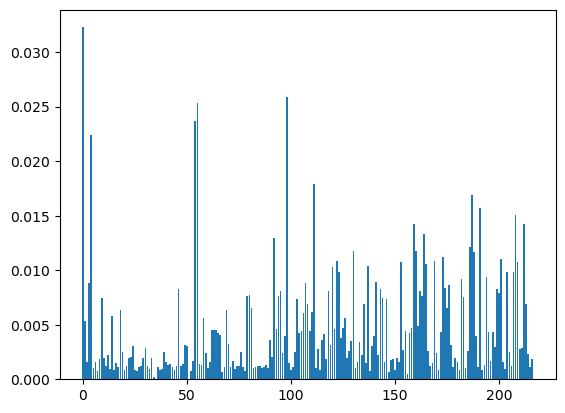

In [94]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [99]:
importance_df = pd.DataFrame({'Features': X_values_train.columns, 'Importance': model.feature_importances_})
importance_df_sorted = importance_df.sort_values(by = 'Importance', ascending=False).head(15)

In [102]:
from tabulate import tabulate
table = tabulate(importance_df_sorted, headers='keys', tablefmt='pretty', showindex=False)

print(table)

+-----------------------------+----------------------+
|          Features           |      Importance      |
+-----------------------------+----------------------+
|      bathrooms_number       | 0.03228125721216202  |
|     zone_grouped_baggio     | 0.02587321773171425  |
|       square_meters_3       | 0.025330189615488052 |
|       square_meters_2       | 0.023693779483437538 |
|        square_meters        | 0.02244037389755249  |
|   zone_grouped_carrobbio    | 0.01787274144589901  |
| zone_grouped_quarto oggiaro | 0.016896752640604973 |
|    zone_grouped_roserio     | 0.015706242993474007 |
|     zone_grouped_vialba     | 0.01509652566164732  |
| zone_grouped_vincenzo monti | 0.014262937940657139 |
|    zone_grouped_moscova     | 0.014252443797886372 |
|    zone_grouped_palestro    | 0.013331261463463306 |
|     floor_semi-basement     | 0.012925341725349426 |
| zone_grouped_quartiere olmi | 0.012126527726650238 |
|    zone_grouped_muggiano    | 0.011788669973611832 |
+---------

## Analysis of Results on validation set

Where does the model make the highest errors? Is there any pattern in big errors?

In [84]:
X_errors = X_values_valid.loc[(np.abs(np.exp(y_pred_valid) - np.array(y_values_valid)) > 200000), :]
X_errors

,alarm system,attic,availability_available_later,availability_available_soon,availability_nan,average_room,balcony,bathrooms_number,bathrooms_number_nan,car_parking_more_garage,...,zone_grouped_turro,zone_grouped_udine,zone_grouped_vercelli - wagner,zone_grouped_vialba,zone_grouped_viale ungheria - mecenate,zone_grouped_vigentino - fatima,zone_grouped_villa san giovanni,zone_grouped_vincenzo monti,zone_grouped_washington,zone_grouped_zara
20,True,False,False,False,False,29.750000,True,3,False,False,...,False,False,False,False,False,False,False,False,False,False
64,False,False,False,True,False,18.000000,True,2,False,False,...,False,False,False,False,False,False,False,False,False,False
65,False,False,False,False,False,39.375000,True,3,False,True,...,False,False,False,False,False,False,False,False,False,False
69,False,False,False,False,False,22.857143,True,3,False,False,...,False,False,False,False,False,False,False,False,False,False
73,False,False,False,False,False,19.000000,True,2,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,True,False,False,False,False,17.800000,True,2,False,False,...,False,False,False,False,False,False,False,False,False,False
1561,False,False,True,False,False,25.000000,True,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1567,True,False,False,False,False,35.000000,True,2,False,False,...,False,False,False,False,False,False,False,False,False,False
1570,True,False,False,False,False,31.250000,True,3,False,False,...,False,False,False,False,False,False,False,False,False,False


In [85]:
print(f'Average square meters for wrongly predicted houses: {X_errors.square_meters.mean()}')
print(f'Average square meters in validation set: {X_values_valid.square_meters.mean()}')

Average square meters for wrongly predicted houses: 175.3153153153153
Average square meters in validation set: 96.22875


In [86]:
print(f'Average bathrooms number for wrongly predicted houses: {X_errors.bathrooms_number.mean()}')
print(f'Average bathrooms number in validation set: {X_values_valid.bathrooms_number.mean()}')

Average bathrooms number for wrongly predicted houses: 2.4324324324324325
Average bathrooms number in validation set: 1.463125


In [87]:
print(f'Average rooms number for wrongly predicted houses: {X_errors.rooms_number.mean()}')
print(f'Average rooms number in validation set: {X_values_valid.rooms_number.mean()}')

Average rooms number for wrongly predicted houses: 4.054054054054054
Average rooms number in validation set: 2.886875


## Export Files

In [96]:
file_name = 'submission_final.txt'
np.savetxt(file_name, y_pred_test, fmt='%d')